# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 2 - Previsão de séries temporais

Estudante: Felipe da Costa Pereira  

Base de dados: Microclima2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

from tqdm.notebook import tqdm


## Preparação para a lista

In [3]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [4]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y


In [5]:
def transform_data(data, lag = 1, test_split = 0.1, normalize = True, category = 'binary'):
    
    '''
    Função para transformação de dados para a 2ª Lista de exercícios.
    A transformação de dados nesta etapa tem duas funções principais: a transformação da série em uma forma tabular para 
    o aprendizado de Redes Neurais e normalização dos dados.
    Parâmetros de entrada:
    - data: base de dados a ser ajeitado.
    - test_split: propoporção da base de dados para teste. Caso seja um float entre 0 e 1, o valor é interpretado como proporção. 
    Caso seja um valor inteiro, é compreendido como o tempo reservado para generalização (e.g. lag = 12 reserva os 12 últimos 
    registros para o teste).
    - normalize: normalização da série. Default True
    - categ: string contendo a codificação a ser realizada para a variável exógena (no caso, o mês).

    A função retorna dois dataframes, sendo o primeiro para treinamento e o segundo para generalização.
    '''

    global _min
    global _max
    
    
    data_values = data.values
    
    if 0 < test_split < 1.0:
        l = data_values.shape[0]
        train_values = data_values[:-int(test_split*l),0].reshape(-1,1)
        test_values = data_values[-int(test_split*l):,0].reshape(-1,1)
        train_idx = data_values[:-int(test_split*l),1].reshape(-1,1)
        test_idx = data_values[-int(test_split*l):,1].reshape(-1,1)
        
    elif test_split > 1 and type(test_split) is int:

        train_values = data_values[:-test_split,0].reshape(-1,1)
        test_values = data_values[-test_split:,0].reshape(-1,1)
        train_idx = data_values[:-test_split,1].reshape(-1,1)
        test_idx = data_values[-test_split:,1].reshape(-1,1)
        
    else:
        print('Test split not understood. Test split should be float between 0 and 1 or integer for index')
    
    assert test_values.shape[0] >= (lag)
    
    _min = np.min(train_values)
    _max = np.max(train_values)
    
    if normalize:
        
        test_values = (test_values - _min)/(_max - _min)
        train_values = (train_values - _min)/(_max - _min)
        
    train_data = np.zeros((train_values.shape[0] - (lag + 1), lag + 2))
    test_data = np.zeros((test_values.shape[0], lag + 2))
    
    
    all_data = np.vstack((train_values,test_values))
    all_idx = np.vstack((train_idx,test_idx))

    new_data = np.zeros((train_values.shape[0] - (lag + 1) + test_values.shape[0],lag + 2))
    
    
    
    for i in range(lag + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]
        

    
    if category == 'binary':
        binary_rep = [np.binary_repr(z,width=4) for z in all_idx.astype('int').reshape(-1,)]
        t0 = np.array([int(v) for s in binary_rep for v in s[0]])
        t1 = np.array([int(v) for s in binary_rep for v in s[1]])
        t2 = np.array([int(v) for s in binary_rep for v in s[2]])
        t3 = np.array([int(v) for s in binary_rep for v in s[3]])
        t = np.vstack((t0,t1,t2,t3)).T
        t = t[-new_data.shape[0]:,:]
        temp_idx = [f'month_{i}' for i in range(4)]
        
    elif category == '1toN':
        pass
    
    else:
        t = (all_idx - np.min(train_idx))/(np.max(train_idx) - np.min(train_idx))
        t = t.reshape(-1,1)
        t = t[-new_data.shape[0]:,:]
        temp_idx = ['month']
    
    
    new_data = np.hstack((t,new_data))
    
    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]
    
    
    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lag,2)] 
    temp_idx.extend(data_columns)
    new_train_df = pd.DataFrame(train_data, columns=temp_idx)
    new_test_df = pd.DataFrame(test_data, columns=temp_idx)
    
    
    
    
    return new_train_df, new_test_df
        
    
    
    

In [6]:
# runnig locally, not necessary becasuse I have copied locally
# !git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
# os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista_2')

In [7]:
path = 'datasets/microclima2/microclima2.csv'
raw_data = pd.read_csv(path)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   144 non-null    float64
 1   time    144 non-null    float64
dtypes: float64(2)
memory usage: 2.4 KB


## Parte 1 - Compreensão do problema

#### 1.	Visualize, em forma de gráfico, a dinâmica temporal da série escolhida. A série é adequada para a modelagem usando Redes Neurais? Caso não seja, que técnicas podem ser aplicadas para ajustar o comportamento da série?

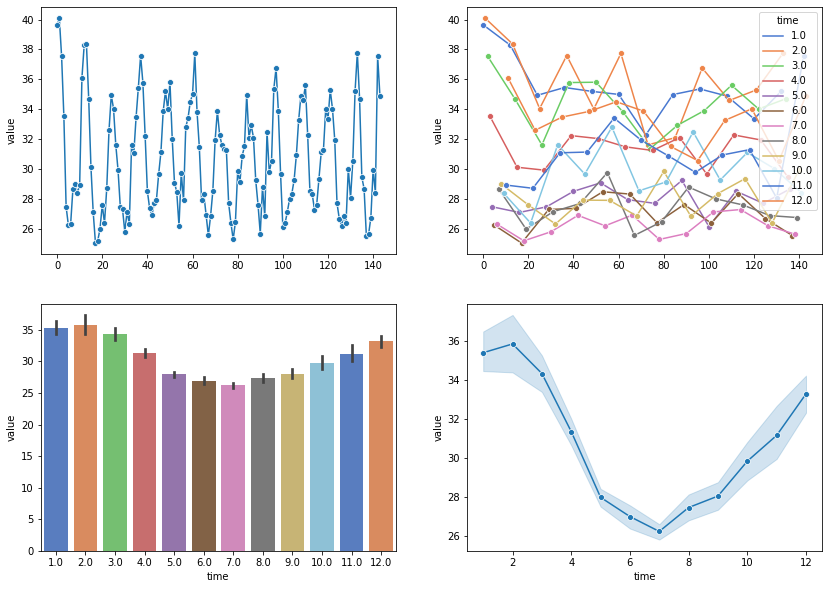

In [8]:
plt.subplots(2,2,figsize=(14,10))
plt.subplot(221)
sns.lineplot(data=raw_data, x=raw_data.index, y='value', marker='o', palette='muted')
plt.subplot(222)
sns.lineplot(data=raw_data, x=raw_data.index, y='value', hue='time', marker='o', palette='muted')
plt.subplot(223)
sns.barplot(data=raw_data, y='value', x='time', palette='muted')
plt.subplot(224)
sns.lineplot(data=raw_data, x='time', y='value', marker='o', palette='muted')
pass;

#### Resposta
Notamos que a série tem sazonalidade e os dados não estão normalizados. O ideal seria considerar como entrada o mês, já que esta variável parece ter boa correlação com a sazonalidade da série

#### 2.	Nesta 2ª lista de exercícios, usaremos uma variável exógena que representa o mês de previsão (i.e. no instante t+1). De que forma esta variável pode auxiliar na previsão da série temporal?

À medida que possui a informação da sazonalidade

Decompondo a série

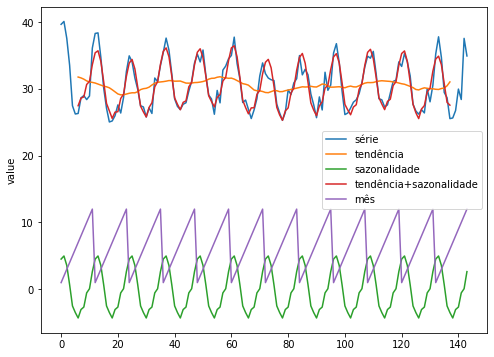

In [9]:
# decompondo a serie
season = seasonal_decompose(raw_data['value'], period=12)

plt.figure(figsize=(8,6))
sns.lineplot(data=raw_data, x=raw_data.index, y='value', label='série')
sns.lineplot(x=raw_data.index, y=season.trend , label='tendência')
sns.lineplot(x=raw_data.index, y=season.seasonal, label='sazonalidade')
sns.lineplot(x=raw_data.index, y=season.seasonal+season.trend, label='tendência+sazonalidade')
sns.lineplot(data=raw_data, x=raw_data.index, y='time', label='mês')

# season.seasonal
pass;

#### 3. Observe que a base de dados não está em um formato adequado para o uso imediato de um modelo de Rede Neural para previsão de séries temporais. Descreva as etapas necessárias de transformação desta base de dados para que possamos utilizá-la no treinamento de uma MLP. Considere que os padrões de entrada (e saída) devem ser normalizados.

R. Além da normalização dos valores de entrada, deve ser feita a codificação do mês

## Parte 2 - Previsão one-step

<b> IMPORTANTE! </b> Este processo não é a previsão multi-step, conforme ensinado em sala de aula. 
Esta parte da lista é importante para evitar erros de avaliação para a previsão de séries temporais com um horizonte de previsão maior que 1.

#### 1.	Execute o script para a previsão one-step. Avalie o resultado (conjunto de treinamento e teste) usando métricas apropriadas, como RMSE e MAE.

In [10]:
prev = 12
train_val, test_val = transform_data(raw_data, lag=12, test_split = prev, normalize=True, category='binary')

In [11]:
train_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,1.0,0.0,0.971445,1.000000,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457
1,0.0,0.0,1.0,1.0,1.000000,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639
2,0.0,1.0,0.0,0.0,0.831055,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537
3,0.0,1.0,0.0,1.0,0.563954,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537,0.136262
4,0.0,1.0,1.0,0.0,0.161359,0.079277,0.084723,0.239008,0.262755,0.222611,0.258260,0.735149,0.880795,0.886457,0.642639,0.337537,0.136262,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1.0,0.0,0.0,0.0,0.149252,0.169844,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248
115,1.0,0.0,0.0,1.0,0.169844,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916
116,1.0,0.0,1.0,0.0,0.286705,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184
117,1.0,0.0,1.0,1.0,0.403197,0.415928,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446


In [12]:
test_val

,month_0,month_1,month_2,month_3,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.0,0.0,0.0,1.0,0.597690,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982
1,0.0,0.0,1.0,0.0,0.552609,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378
2,0.0,0.0,1.0,1.0,0.681684,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972
3,0.0,1.0,0.0,0.0,0.596855,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441
4,0.0,1.0,0.0,1.0,0.458879,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284
5,0.0,1.0,1.0,0.0,0.176922,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235
6,0.0,1.0,1.0,1.0,0.108941,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666
7,1.0,0.0,0.0,0.0,0.077823,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692
8,1.0,0.0,0.0,1.0,0.122248,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692,0.327107
9,1.0,0.0,1.0,0.0,0.089916,0.331184,0.200446,0.365814,0.675982,0.847378,0.641972,0.293441,0.241284,0.033235,0.039666,0.113692,0.327107,0.223576


In [13]:
train_values = train_val.values

X_train = train_values[:,:-1]
y_train = train_values[:,-1]

test_values = test_val.values

X_test = test_values[:,:-1]
y_test = test_values[:,-1]

X_train.shape

(119, 17)

In [14]:
train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))

In [15]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [16]:
n_input = X_train.shape[1]
n_output = 1
hidden_neurons = 20

In [17]:
def train(model, train_loader, epochs, device, lr, skip=50):

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  history = {'loss_train': []}

  for e in tqdm(range(1, epochs+1)):
    
    y_hat = np.array([])

    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X, y = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        
        y_p = torch.argmax(y_pred, dim=1)
        y_hat = np.concatenate((y_hat, y_p))
    
    #_, val_loss, val_acc = evaluate(model, val_loader, criterion, device, binary=binary)

    history['loss_train'].append(train_epoch_loss)
    
    if e % skip == 0:
      print(f'Epoch {e+0:03} | Train Loss: {train_epoch_loss/len(train_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss/len(val_loader):.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc/len(val_loader):.4f}')
  return history, y_hat


In [18]:
model = NeuralNetwork(n_input = n_input, n_output=n_output, hidden_neurons = hidden_neurons, hidden_activation='sigmoid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lr = 0.05
epochs = 1000

history, y_hat = train(model, train_loader, epochs, device, lr)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 050 | Train Loss: 0.033
Epoch 100 | Train Loss: 0.020
Epoch 150 | Train Loss: 0.013
Epoch 200 | Train Loss: 0.011
Epoch 250 | Train Loss: 0.010
Epoch 300 | Train Loss: 0.010
Epoch 350 | Train Loss: 0.010
Epoch 400 | Train Loss: 0.010
Epoch 450 | Train Loss: 0.010
Epoch 500 | Train Loss: 0.010
Epoch 550 | Train Loss: 0.010
Epoch 600 | Train Loss: 0.010
Epoch 650 | Train Loss: 0.009
Epoch 700 | Train Loss: 0.009
Epoch 750 | Train Loss: 0.009
Epoch 800 | Train Loss: 0.009
Epoch 850 | Train Loss: 0.009
Epoch 900 | Train Loss: 0.009
Epoch 950 | Train Loss: 0.009
Epoch 1000 | Train Loss: 0.009


In [33]:
y_pred = model(torch.from_numpy(X_test).float())
y_hat = y_pred.detach().numpy()

y_pred, y_hat

(tensor([[0.5745],
         [0.6823],
         [0.6241],
         [0.4794],
         [0.2349],
         [0.1826],
         [0.0555],
         [0.1499],
         [0.0972],
         [0.2760],
         [0.3769],
         [0.5571]], grad_fn=<AddmmBackward0>),
 array([[0.57446516],
        [0.68227726],
        [0.6241091 ],
        [0.47935435],
        [0.23485054],
        [0.1826113 ],
        [0.05552463],
        [0.14990823],
        [0.09717716],
        [0.27595186],
        [0.3769384 ],
        [0.55714184]], dtype=float32))

Erro MSE = 6.95 
Erro MAE = 1.899


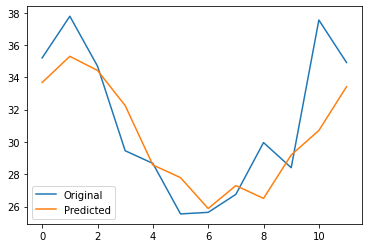

In [66]:
# desnormalizando as previsões:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_hat*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')


#### 2.	Modifique a técnica de codificação mensal de ‘binário’ para ‘numérico’. Qual a mudança existente na arquitetura da Rede Neural? Analise o resultado (conjunto de treinamento e teste), usando as métricas adequadas.

## Parte 3 - Previsão multi-step

#### 1.	Esquematize como você implementaria o processo de previsão multi-step. Descreva todos os passos necessários, e em seguida compare com o código fornecido para a previsão. 

In [21]:
def multi_step(model, X_test, cod='numeric'):
  y_result = []
  X_t = np.copy(X_test[0])
  for i in range(prev):
      y_hat = model(torch.from_numpy(X_t).float())
      
      if cod == 'numeric':

        #Ajeitando a codificação. Transformamos para o valor do mês e somamos 1 (para o próximo passo) e 
        #depois pegamos o resto da divisão por 12 (para que o mês fique sempre entre 0 e 11)
        tmp = int(X_t[0] * 12 + 1) % 12
        
        #Alterando a variável mês
        X_t[0] = tmp/12
        
        #Movendo todos os registros, 'deslizando a janela'
        X_t[1:X_t.shape[0]-1] = X_t[2:]

      elif cod == 'binary':
        pass

      else:
        print('Erro de codificação.')
        break
      

      X_t[-1] = y_hat
      
      y_result.append(y_hat[0].detach().numpy())


  return np.array(y_result)

#### 2.	Faça a previsão multi-step para o horizonte de previsão igual a 12. Perceba que o resultado da métrica é, geralmente, pior do que o apresentado para a previsão one-step. Por quê? É justo comparar o resultado deste item com o que foi apresentado anteriormente? Discuta. 

In [22]:
y_result = multi_step(model, X_test, cod='numeric')

Erro MSE = 5.868 
Erro MAE = 1.818


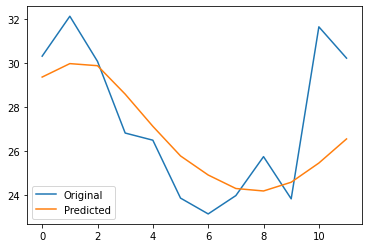

In [23]:
orig_y_eval = y_test*(_max-_min) + _min
orig_y_hat = y_result*(_max-_min) + _min
mae_error = mean_absolute_error(orig_y_eval, orig_y_hat)
mse_error = mean_squared_error(orig_y_eval, orig_y_hat)

plt.plot(orig_y_eval)
plt.plot(orig_y_hat)
plt.legend(['Original','Predicted'])

print(f'Erro MSE = {round(mse_error,3)} \nErro MAE = {round(mae_error,3)}')

#### 3.	Modifique o tamanho da janela de entrada do modelo. Analise os resultados, utilizando as métricas adequadas. 

#### 4.	Modifique a topologia da rede para obter um melhor desempenho. Altere seus parâmetros (e.g. número de processadores na camada escondida, tipo de função na camada de saída) e avalie o desempenho.

#### 5. Modifique a função de previsão multi-step para permitir a codificação binária da variável mês. Em seguida, treine um modelo MLP usando a codificação binária para a variável exógena e faça a previsão multi-step e analise o resultado. 

OBS: Para este item, basta alterar a atualização da variável exógena na condição desejada (no caso, cod = 'binary')